In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import json
from tqdm import tqdm
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error

In [ ]:
dataset = pd.read_csv('/content/brenda.csv')

In [ ]:
dataset

,Unnamed: 0,sequence,Unnamed: 0.1,acc,mean_pH,std,split_0,split_1,lower_pH,upper_pH,len,0.2_split,0.4_split,0.6_split,seq_len
0,0,AAGAEGKGTSFXFPQITLWQRPLVTVXIEGQLREALLDTGADDTVF...,104593.5,256230.0,7.700,0.424264,1,0,NaN,NaN,NaN,train,train,train,453
1,1,AAGQEGQGAISSFSFPQITLWQRPLVTVRIEGQLIEALLDTGADDT...,114869.0,346415.0,7.700,0.424264,1,0,NaN,NaN,NaN,train,train,train,440
2,2,AAICIYPRFIPIARKTLKEQGTPEIRIATVTNFPHGNDDIEIALAE...,103510.8,289661.8,7.900,0.675463,1,0,NaN,NaN,NaN,test,train,test,216
3,3,AAICIYPRFIPIARKTLKEQGTPEIRIATVTNFPHGNDDIEIALAE...,103487.8,289638.8,7.900,0.675463,1,0,NaN,NaN,NaN,test,train,test,216
4,4,AALAGYKWLGRGDKNTADGAAVNAMRIMLNQVNIDGTIVIGEGEID...,144346.5,442634.5,7.650,0.212132,1,0,NaN,NaN,NaN,test,test,test,321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40920,40920,VIRSENFTNNARTIIVQLKEAVEINCTRPYNNTRRSIHIGPGRAFF...,2839.0,O92261,7.625,0.176777,0,1,6.750000,8.500000,199.0,train,train,train,199
40921,40921,VSHRVRTCDTVDGGYQCFPQLSHRWGQYSPYFSLANTGLPSEVPEK...,2840.0,D9I0I9,5.250,0.353553,0,1,4.250000,6.250000,447.0,test,test,test,447
40922,40922,WHQWKRMYNKEYNGADDEHRRNIWEKNVKHIEEHNLRHDRGLVTYK...,2841.0,B3TM67,5.500,0.707107,0,1,5.500000,5.500000,306.0,train,test,test,306
40923,40923,WLLVLSALVAFAECFHKIPLIKGKTAREALQEKGIWEEYRKEHPYN...,2842.0,Q6HA04,2.250,0.250000,0,1,1.333333,3.166667,373.0,test,test,test,373


In [ ]:
# Getting k-mers from sequences
def get_k_mers(seq, n):
  return[seq[i:i+n] for i in range(len(seq)-(n-1))]

In [ ]:
# Making the splits (Homology split)

def make_homology_split(df, thr):
  df['test']= df['{}_split'.format(thr)].apply(lambda x: 0 if x == 'train' else 1)
  
def get_k_mer_table(df, k):
  bad_aas = {'X','Y','U','B', 'O'}
  df['kmers'] = df['sequence'].apply(lambda x: get_k_mers(x,k))
  kmers = df[df['test']==0]['kmers'].values
  mean_phs = df[df['test']==0]['mean_pH'].values

  print('Filling the table of kmers with train examples...')

  kmer_dict = {}
  for m_ph, kmers_list in tqdm(zip(mean_phs, kmers)):
    for kmer in kmers_list:
      if bad_aas.intersection(kmer):
        continue
      if kmer_dict.get(kmer) is None:
        kmer_dict[kmer]=(m_ph,1)
      else:
        previous_vals = np.array(kmer_dict[kmer])
        kmer_dict[kmer] = tuple(previous_vals+(m_ph,1))

  print('Averaging kmers...')
  for kmer in tqdm(kmer_dict):
    m_phs, N = kmer_dict[kmer]
    m_ph = m_phs/N
    kmer_dict[kmer] = m_ph
  return kmer_dict

In [ ]:
def scoring_function(kmers, kmer_dict):
  mean_ph = -1
  count = 0

  for kmer in kmers:
    values = kmer_dict.get(kmer)
    if values is not None:
      m_ph = values
      mean_ph += m_ph
      count +=1

  if (mean_ph != -1):
    return (mean_ph + 1) / count
  else:
    return None

In [ ]:
output_dir = Path('/content/output')

In [ ]:
# Function to run the experiments
def experiment(df, k, output_csv):
  print('Scoring dataset...')
  kmer_dict = get_k_mer_table(df, k)
  kmers = df['kmers'].values
  predicted_phs = []
  for seq_kmers in kmers:
    predicted_phs.append(scoring_function(seq_kmers, kmer_dict))
  df['predicted_pH'] = predicted_phs
  print(df['predicted_pH'])
  df.to_csv(output_dir.joinpath(output_csv))

We will use threshold 0.2 because it was shown previously that it gives the best result

In [ ]:
# Running the experiment with a homology split
for k in range(1,16):
  make_homology_split(dataset, 0.2)
  name = 'brenda_k_{}_thr_0.2.csv'.format(k)
  experiment(dataset, k, name)

Filling the table of kmers with train examples...


30693it [01:08, 451.17it/s]


Averaging kmers...


100%|██████████| 20/20 [00:00<00:00, 58867.42it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [01:05, 469.94it/s]


Averaging kmers...


100%|██████████| 20/20 [00:00<00:00, 147168.56it/s]


0        7.532508
1        7.532863
2        7.534696
3        7.534604
4        7.536107
           ...   
40920    7.530738
40921    7.530720
40922    7.531633
40923    7.526116
40924    7.529921
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [01:06, 462.58it/s]


Averaging kmers...


100%|██████████| 395/395 [00:00<00:00, 672382.34it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [01:03, 480.22it/s]


Averaging kmers...


100%|██████████| 395/395 [00:00<00:00, 595310.84it/s]


0        7.537902
1        7.538777
2        7.536503
3        7.536479
4        7.538133
           ...   
40920    7.521380
40921    7.527413
40922    7.528172
40923    7.514112
40924    7.521718
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [01:05, 470.22it/s]


Averaging kmers...


100%|██████████| 7033/7033 [00:00<00:00, 644593.67it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [01:05, 470.51it/s]


Averaging kmers...


100%|██████████| 7033/7033 [00:00<00:00, 971209.30it/s]


0        7.563004
1        7.564940
2        7.517680
3        7.517369
4        7.539637
           ...   
40920    7.470933
40921    7.514887
40922    7.484127
40923    7.474171
40924    7.484151
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [01:48, 283.81it/s]


Averaging kmers...


100%|██████████| 124397/124397 [00:00<00:00, 242164.24it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [01:14, 410.99it/s]


Averaging kmers...


100%|██████████| 124397/124397 [00:00<00:00, 708293.63it/s]


0        7.572165
1        7.577659
2        7.486697
3        7.481515
4        7.463921
           ...   
40920    7.363598
40921    7.303439
40922    7.133943
40923    7.290097
40924    7.181974
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [01:32, 330.34it/s]


Averaging kmers...


100%|██████████| 910860/910860 [00:01<00:00, 640792.44it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [01:04, 477.07it/s]


Averaging kmers...


100%|██████████| 910860/910860 [00:01<00:00, 718803.84it/s]


0        7.569435
1        7.584500
2        7.682231
3        7.678695
4        7.521310
           ...   
40920    7.476763
40921    7.089577
40922    6.145769
40923    7.015242
40924    6.188391
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [01:27, 348.83it/s] 


Averaging kmers...


100%|██████████| 1502624/1502624 [00:01<00:00, 902675.05it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:56, 545.19it/s] 


Averaging kmers...


100%|██████████| 1502624/1502624 [00:01<00:00, 842915.44it/s]


0        7.571152
1        7.588328
2        7.881221
3        7.880869
4        7.635805
           ...   
40920    7.608205
40921    6.337689
40922    5.625759
40923    6.212293
40924    5.451136
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:54, 561.05it/s] 


Averaging kmers...


100%|██████████| 1581092/1581092 [00:01<00:00, 913508.54it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:56, 539.14it/s] 


Averaging kmers...


100%|██████████| 1581092/1581092 [00:01<00:00, 899106.04it/s]


0        7.571161
1        7.590940
2        7.897852
3        7.897810
4        7.652212
           ...   
40920    7.627611
40921    5.475000
40922    5.548107
40923    4.466964
40924    5.330745
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:52, 582.61it/s] 


Averaging kmers...


100%|██████████| 1586491/1586491 [00:01<00:00, 939534.72it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:52, 585.24it/s] 


Averaging kmers...


100%|██████████| 1586491/1586491 [00:01<00:00, 942515.79it/s]


0        7.570785
1        7.593271
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921    5.250000
40922    5.520113
40923    3.981771
40924    5.324265
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:55, 556.29it/s] 


Averaging kmers...


100%|██████████| 1583758/1583758 [00:01<00:00, 933353.73it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:52, 582.54it/s] 


Averaging kmers...


100%|██████████| 1583758/1583758 [00:01<00:00, 924031.61it/s]


0        7.570230
1        7.595200
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921    5.250000
40922    5.503849
40923    3.840000
40924    5.317069
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:58, 520.77it/s] 


Averaging kmers...


100%|██████████| 1579226/1579226 [00:01<00:00, 938002.97it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:55, 548.91it/s] 


Averaging kmers...


100%|██████████| 1579226/1579226 [00:01<00:00, 907441.37it/s]


0        7.570547
1        7.597255
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.499437
40923    3.987500
40924    5.309033
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:57, 535.54it/s] 


Averaging kmers...


100%|██████████| 1573591/1573591 [00:01<00:00, 926290.50it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:50, 611.49it/s] 


Averaging kmers...


100%|██████████| 1573591/1573591 [00:01<00:00, 905231.89it/s]


0        7.569133
1        7.599412
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.496362
40923    3.987500
40924    5.306346
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:47, 645.33it/s] 


Averaging kmers...


100%|██████████| 1567805/1567805 [00:01<00:00, 893985.02it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:47, 640.08it/s] 


Averaging kmers...


100%|██████████| 1567805/1567805 [00:01<00:00, 905723.53it/s]


0        7.568699
1        7.601902
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.497251
40923    3.987500
40924    5.303354
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:48, 627.36it/s] 


Averaging kmers...


100%|██████████| 1561540/1561540 [00:01<00:00, 867928.86it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:51, 598.63it/s] 


Averaging kmers...


100%|██████████| 1561540/1561540 [00:01<00:00, 853284.13it/s]


0        7.568861
1        7.604500
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.500000
40923         NaN
40924    5.300000
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:46, 663.85it/s] 


Averaging kmers...


100%|██████████| 1554895/1554895 [00:01<00:00, 859514.99it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:45, 669.90it/s] 


Averaging kmers...


100%|██████████| 1554895/1554895 [00:01<00:00, 911092.78it/s]


0        7.570209
1        7.606801
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.500000
40923         NaN
40924    5.300000
Name: predicted_pH, Length: 40925, dtype: float64
Filling the table of kmers with train examples...


30693it [00:45, 677.92it/s] 


Averaging kmers...


100%|██████████| 1548290/1548290 [00:01<00:00, 904449.12it/s]


Scoring dataset...
Filling the table of kmers with train examples...


30693it [00:44, 687.55it/s] 


Averaging kmers...


100%|██████████| 1548290/1548290 [00:01<00:00, 873415.98it/s]


0        7.571944
1        7.609356
2        7.900000
3        7.900000
4        7.650000
           ...   
40920    7.625000
40921         NaN
40922    5.500000
40923         NaN
40924    5.300000
Name: predicted_pH, Length: 40925, dtype: float64


In [ ]:
# Defining the function to calculate performance
def calculate_metrics(df):
  df['error'] = np.abs(df['mean_pH'] - df['predicted_pH'])
  y_pred = df[(df['test'] ==1) & (df['predicted_pH'].notna())]['predicted_pH'].values
  y_true = df[(df['test'] ==1) & (df['predicted_pH'].notna())]['mean_pH'].values
  N= df[df['test']==1].shape[0]

  mae = mean_absolute_error(y_true, y_pred)
  spr = spearmanr(y_pred, y_true)[0]
  perc_of_scored_seqs = 100*len(y_pred)/N

  print('Mean absolute error:', round(mae,2))
  print('Spearman correlation coefficient:', round(spr,2))
  print('Number of scored sequences:', len(y_pred))
  print('Percentage of scored sequences:', round(perc_of_scored_seqs, 1))
  return round(mae,2), round(spr,2), len(y_pred), round(perc_of_scored_seqs, 1)

In [ ]:
# Printing out the resulting stats

%%capture

k_1metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_1_thr_0.2.csv'))
k_2metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_2_thr_0.2.csv'))
k_3metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_3_thr_0.2.csv'))
k_4metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_4_thr_0.2.csv'))
k_5metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_5_thr_0.2.csv'))
k_6metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_6_thr_0.2.csv'))
k_7metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_7_thr_0.2.csv'))
k_8metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_8_thr_0.2.csv'))
k_9metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_9_thr_0.2.csv'))
k_10metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_10_thr_0.2.csv'))
k_11metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_11_thr_0.2.csv'))
k_12metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_12_thr_0.2.csv'))
k_13metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_13_thr_0.2.csv'))
k_14metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_14_thr_0.2.csv'))
k_15metrics = calculate_metrics(pd.read_csv('/content/output/brenda_k_15_thr_0.2.csv'))


column_list = ['MAE', 'Spearman Correlation Rank', '# of scored sequences', '% of scored sequences']

stats = pd.DataFrame(list(zip(k_1metrics, k_2metrics, k_3metrics, k_4metrics, k_5metrics,k_6metrics, k_7metrics,
                              k_8metrics, k_9metrics, k_10metrics, k_11metrics, k_12metrics, k_13metrics,
                              k_14metrics, k_15metrics))).T
stats.columns = column_list
parameters = [f'k={i}' for i in range(1,16)]
stats.insert(loc=0, column = 'Parameter Set', value = parameters)

In [ ]:
stats

,Parameter Set,MAE,Spearman Correlation Rank,# of scored sequences,% of scored sequences
0,k=1,0.62,0.19,10232.0,100.0
1,k=2,0.62,0.20,10232.0,100.0
2,k=3,0.62,0.27,10232.0,100.0
3,k=4,0.60,0.55,10232.0,100.0
4,k=5,0.45,0.71,10232.0,100.0
5,k=6,0.26,0.79,10232.0,100.0
6,k=7,0.21,0.83,10066.0,98.4
7,k=8,0.17,0.86,9511.0,93.0
8,k=9,0.14,0.89,9189.0,89.8
9,k=10,0.13,0.89,8997.0,87.9


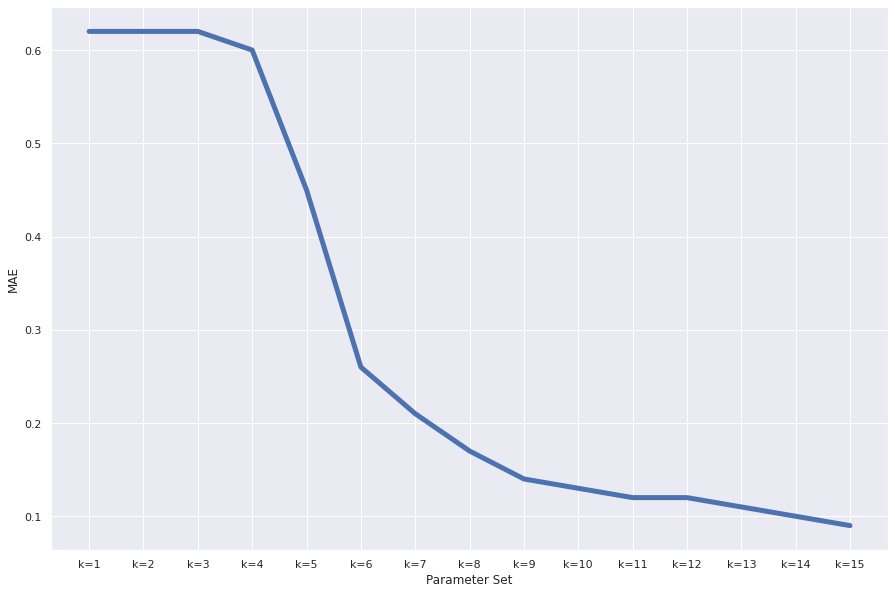

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=stats, x='Parameter Set', y='MAE', color = 'b', linewidth = 5)
plt.show()

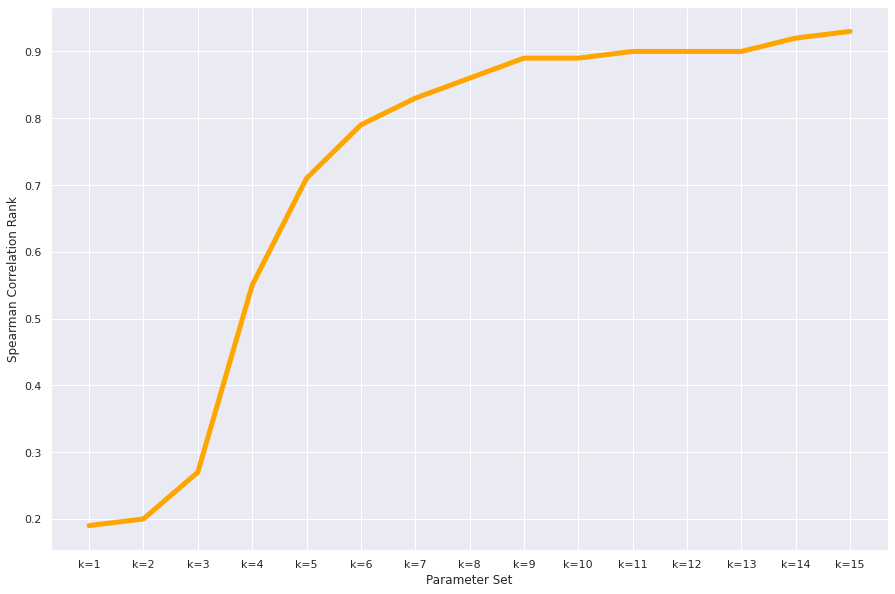

In [ ]:
plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=stats, x='Parameter Set', y='Spearman Correlation Rank', color = 'orange', linewidth = 5);
plt.show()

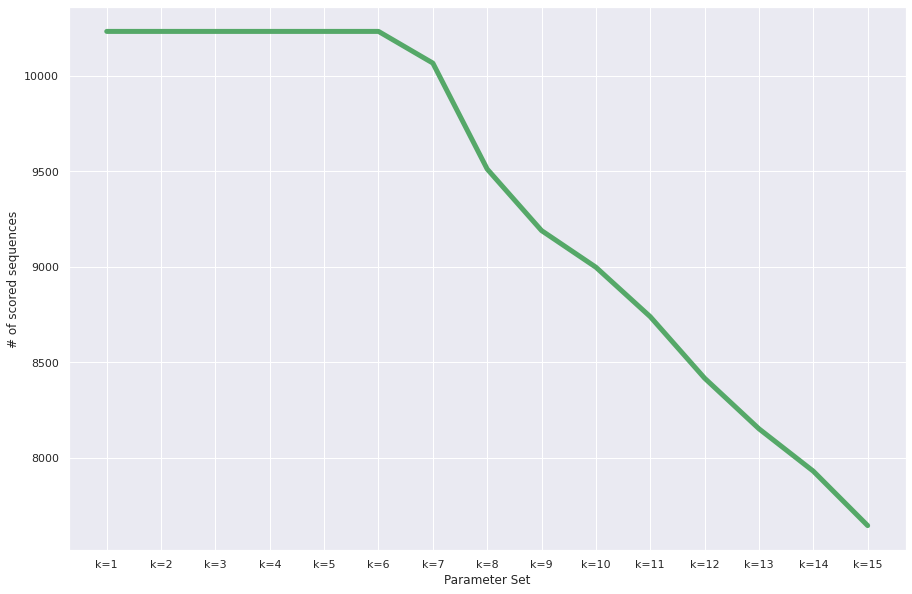

In [ ]:
plt.figure(figsize=(15,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=stats, x='Parameter Set', y='# of scored sequences', color = 'g', linewidth = 5);
plt.show()

In [ ]:
sum_1 = stats['MAE'].sum()
sum_2 = stats['Spearman Correlation Rank'].sum()
sum_3 = stats['# of scored sequences'].sum()
stats['MAE_percent'] = stats['MAE']/sum_1
stats['spear_percent'] = stats['Spearman Correlation Rank']/sum_2
stats['seq_percent']= stats['# of scored sequences']/sum_3

In [ ]:
df = stats.drop(['MAE','Spearman Correlation Rank','# of scored sequences', '% of scored sequences'], axis=1)
df = df.melt('Parameter Set', var_name='cols', value_name='vals')
df

,Parameter Set,cols,vals
0,k=1,MAE_percent,0.142202
1,k=2,MAE_percent,0.142202
2,k=3,MAE_percent,0.142202
3,k=4,MAE_percent,0.137615
4,k=5,MAE_percent,0.103211
5,k=6,MAE_percent,0.059633
6,k=7,MAE_percent,0.048165
7,k=8,MAE_percent,0.038991
8,k=9,MAE_percent,0.032110
9,k=10,MAE_percent,0.029817


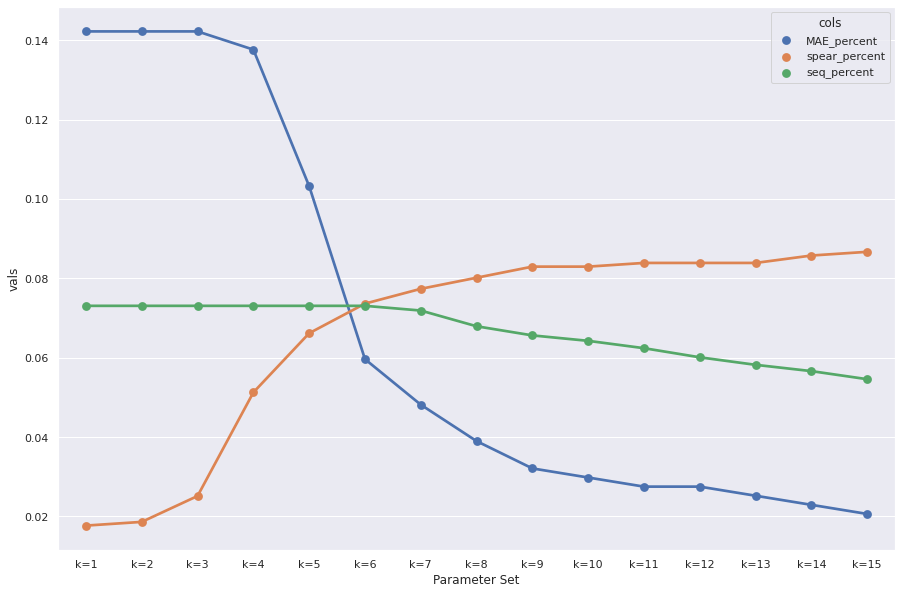

In [ ]:
plt.figure(figsize=(15,10))
sns.pointplot(x="Parameter Set", y="vals", hue='cols', data=df);

Based on these plots, the optimal k value is about 6-7-8